### Step 1: Import Data with CoinPaprika API (https://api.coinpaprika.com/)

In [2]:
import Coinpaprika
import pandas as pd                        
from pytrends.request import TrendReq
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

In [3]:
api_client = Coinpaprika.Client()
market_overview = api_client.global_market_overview()

#print(market_overview)

all_coins = api_client.coins()
for i  in range(0, 10):
    print(all_coins[i]['id'])

btc-bitcoin
eth-ethereum
bnb-binance-coin
xrp-xrp
doge-dogecoin
usdt-tether
ada-cardano
dot-polkadot
bch-bitcoin-cash
ltc-litecoin


## get historical data 

In [4]:
from datetime import datetime, timedelta

coin = 'btc-bitcoin'
color = 'green'

hist = api_client.coins.historical_OHLC(
    coin_id=coin,
    start=datetime.now() - timedelta(weeks=52) - timedelta(days=0),
    end=datetime.now() - timedelta(days=0)
)
# TODO: "clean up" data (na's, outliers, etc.)

In [5]:
alldata = []

for i in range(1,len(hist)):
    alldata.append({
        "close": hist[i-1]['close']
    })

In [6]:
print(alldata[0])
print(len(alldata))

{'close': 8762.78233268}
364


### New Model with Keras


In [7]:
alldataFrame = pd.DataFrame(alldata)

In [8]:
scaler = MinMaxScaler()

close_price = alldataFrame["close"].values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

SEQ_LEN = 100

In [20]:
def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

In [28]:
def preprocess(data_raw, seq_len, train_split):
    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test

In [29]:
X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.9)
print(X_train.shape)
print(X_test.shape)

(237, 99, 1)
(27, 99, 1)


In [30]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1
BATCH_SIZE = 64

model = keras.Sequential()

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True), input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))
model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))
model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))
model.add(Dense(units=1))
model.add(Activation('linear'))

model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

history = model.fit(
    X_train,
    y_train,
    epochs=15,
    batch_size=BATCH_SIZE,
    shuffle=False,
    validation_split=0.1
)

Epoch 1/15
4/4 [==============================] - 9s 833ms/step - loss: 0.0155 - val_loss: 0.0055
Epoch 2/15
4/4 [==============================] - 1s 333ms/step - loss: 0.0416 - val_loss: 0.2702
Epoch 3/15
4/4 [==============================] - 1s 315ms/step - loss: 0.0257 - val_loss: 0.0946
Epoch 4/15
4/4 [==============================] - 1s 343ms/step - loss: 0.0066 - val_loss: 0.0320
Epoch 5/15
4/4 [==============================] - 1s 343ms/step - loss: 0.0301 - val_loss: 0.0069
Epoch 6/15
4/4 [==============================] - 1s 335ms/step - loss: 0.0101 - val_loss: 0.0332
Epoch 7/15
4/4 [==============================] - 1s 353ms/step - loss: 0.0069 - val_loss: 0.0083
Epoch 8/15
4/4 [==============================] - 1s 335ms/step - loss: 0.0017 - val_loss: 0.0159
Epoch 9/15
4/4 [==============================] - 1s 338ms/step - loss: 0.0039 - val_loss: 0.0169
Epoch 10/15
4/4 [==============================] - 1s 338ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 11/15
4/4 [==

In [31]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 83ms/step - loss: 0.0063


0.00633768318220973

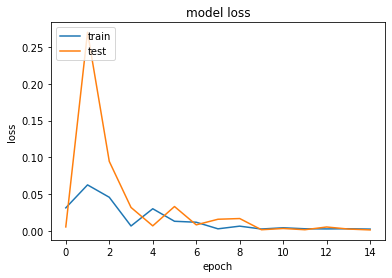

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

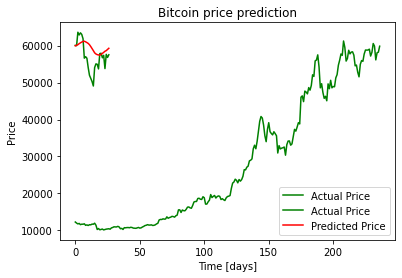

In [36]:
y_hat = model.predict(X_test)

y_train_inverse = scaler.inverse_transform(y_train)
y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_train_inverse, label="Actual Price", color='green')
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();